In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
# Load multiple datasets
files = ["uber-raw-data-apr14.csv", "uber-raw-data-may14.csv", "uber-raw-data-jun14.csv",
         "uber-raw-data-jul14.csv", "uber-raw-data-aug14.csv", "uber-raw-data-sep14.csv"]

In [3]:
dataframes = [pd.read_csv(f'kaggle/months/{file}') for file in files]
uber_data = pd.concat(dataframes, ignore_index=True)
uber_data.head(),uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


(          Date/Time      Lat      Lon    Base
 0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
 1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
 2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
 3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
 4  4/1/2014 0:33:00  40.7594 -73.9722  B02512,
 None)

In [4]:

# Convert Date/Time to datetime object
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'])
uber_data['Hour'] = uber_data['Date/Time'].dt.hour
uber_data['Day'] = uber_data['Date/Time'].dt.day
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.dayofweek
uber_data['Month'] = uber_data['Date/Time'].dt.month

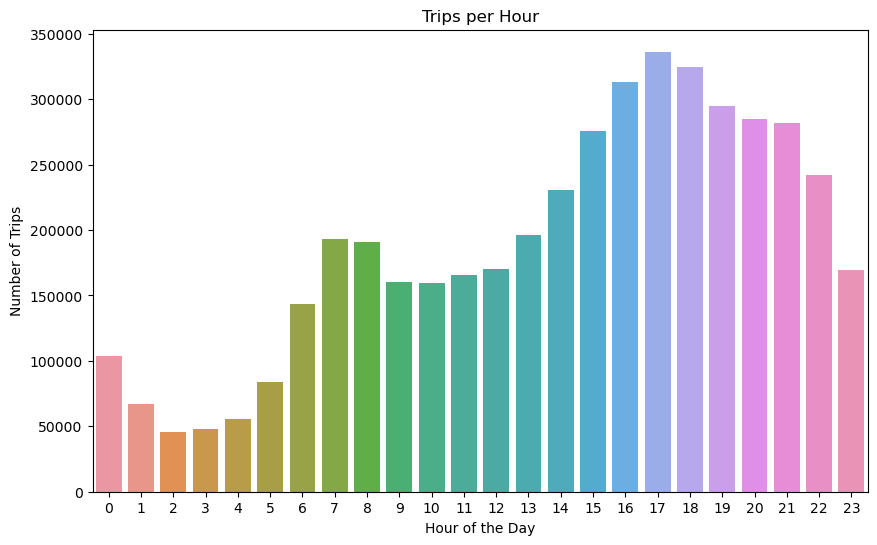

In [5]:

# Exploratory Data Analysis
plt.figure(figsize=(10,6))
sns.countplot(x=uber_data['Hour'])
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()

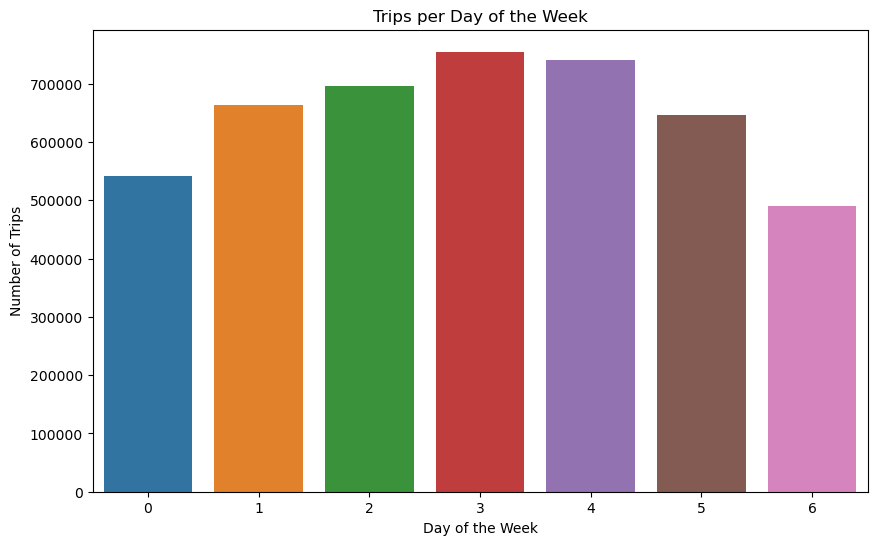

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x=uber_data['DayOfWeek'])
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.show()

In [7]:

# Seasonal Decomposition
uber_data.set_index('Date/Time', inplace=True)
hourly_counts = uber_data.resample('H').size()
decomposition = seasonal_decompose(hourly_counts, model='additive', period=24)


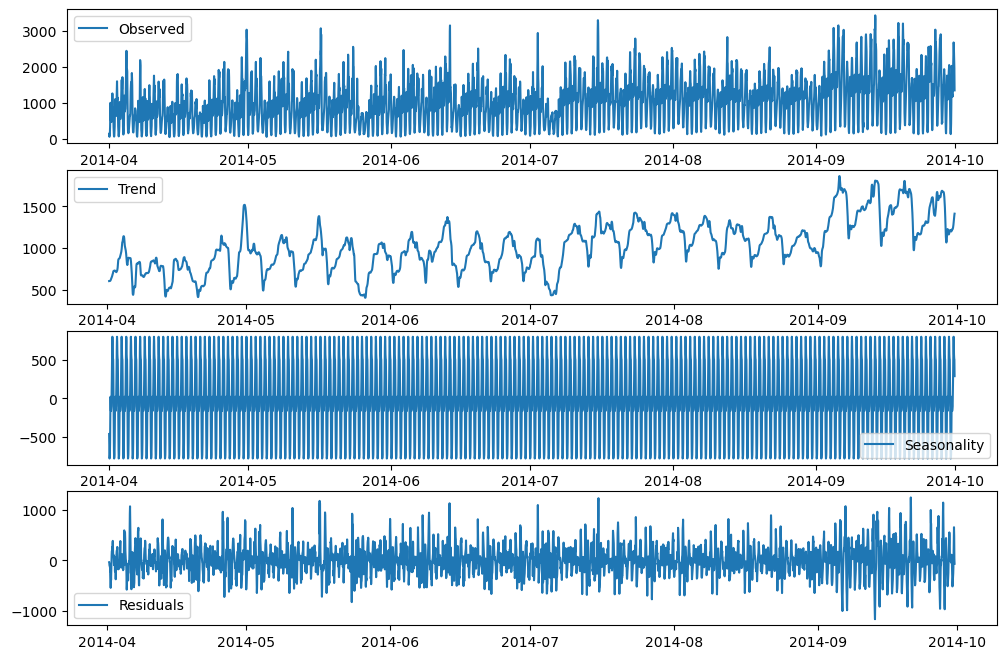

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(decomposition.observed, label='Observed')
plt.legend()
plt.subplot(4,1,2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()
plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend()
plt.subplot(4,1,4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend()
plt.show()

In [9]:
hourly_counts = uber_data.resample('H').size()
uber_data = hourly_counts.to_frame(name='Count')
uber_data

,Count
Date/Time,
2014-04-01 00:00:00,138
2014-04-01 01:00:00,66
2014-04-01 02:00:00,53
2014-04-01 03:00:00,93
2014-04-01 04:00:00,166
...,...
2014-09-30 18:00:00,2625
2014-09-30 19:00:00,2404
2014-09-30 20:00:00,2246


In [10]:
cutoff_date = '2014-09-15'
train_data = uber_data.loc[:cutoff_date]
test_data = uber_data.loc[cutoff_date:]

In [11]:
def create_lagged_features(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [12]:
X_train, y_train = create_lagged_features(train_data['Count'].values)
X_test, y_test = create_lagged_features(np.concatenate([train_data['Count'].values[-24:], test_data['Count'].values]))

In [13]:
# Model Training
seed = 42
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)
xgb_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
xgb_search = GridSearchCV(xgb_model, xgb_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
xgb_search.fit(X_train, y_train)
xgb_pred = xgb_search.best_estimator_.predict(X_test)
print(f'XGBoost MAPE: {mean_absolute_percentage_error(y_test, xgb_pred):.2%}')


XGBoost MAPE: 8.51%


In [15]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=seed)
rf_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_search = GridSearchCV(rf_model, rf_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_pred = rf_search.best_estimator_.predict(X_test)
print(f'Random Forest MAPE: {mean_absolute_percentage_error(y_test, rf_pred):.2%}')


Random Forest MAPE: 8.77%


In [16]:
# Gradient Boosting Model
gbr_model = GradientBoostingRegressor(random_state=seed)
gbr_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gbr_search = GridSearchCV(gbr_model, gbr_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gbr_search.fit(X_train, y_train)
gbr_pred = gbr_search.best_estimator_.predict(X_test)
print(f'GBTR MAPE: {mean_absolute_percentage_error(y_test, gbr_pred):.2%}')


GBTR MAPE: 8.90%


In [17]:
# Ensemble Model
weights = np.array([0.4, 0.3, 0.3])
ensemble_pred = (weights[0] * xgb_pred + weights[1] * rf_pred + weights[2] * gbr_pred)
print(f'Ensemble MAPE: {mean_absolute_percentage_error(y_test, ensemble_pred):.2%}')


Ensemble MAPE: 8.38%


In [18]:

# Evaluation
print(f'XGBoost MAPE: {mean_absolute_percentage_error(y_test, xgb_pred):.2%}')
print(f'Random Forest MAPE: {mean_absolute_percentage_error(y_test, rf_pred):.2%}')
print(f'GBTR MAPE: {mean_absolute_percentage_error(y_test, gbr_pred):.2%}')
print(f'Ensemble MAPE: {mean_absolute_percentage_error(y_test, ensemble_pred):.2%}')


XGBoost MAPE: 8.51%
Random Forest MAPE: 8.77%
GBTR MAPE: 8.90%
Ensemble MAPE: 8.38%


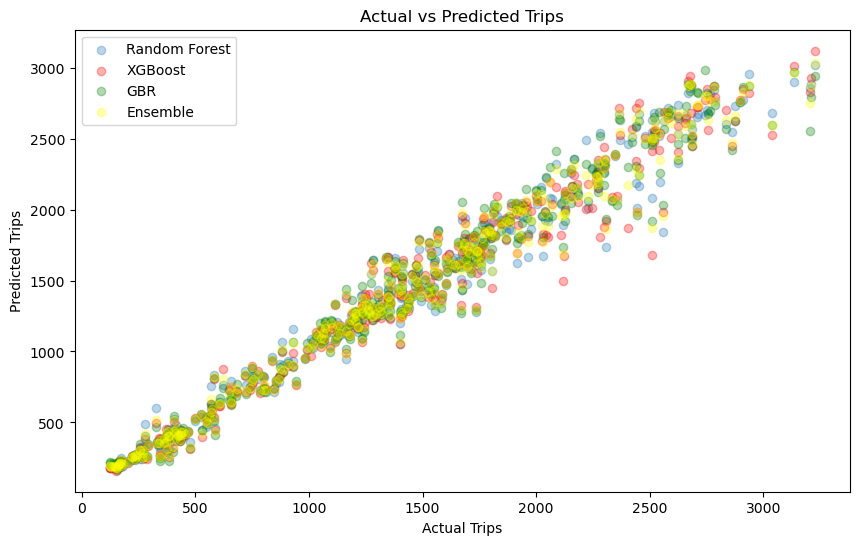

In [19]:
# Visualization of Predictions
plt.figure(figsize=(10,6))
plt.scatter(y_test, rf_pred, alpha=0.3, label='Random Forest')
plt.scatter(y_test, xgb_pred, alpha=0.3, label='XGBoost', color='red')
plt.scatter(y_test, gbr_pred, alpha=0.3, label='GBR', color='green')
plt.scatter(y_test, ensemble_pred, alpha=0.3, label='Ensemble', color='yellow')
plt.xlabel('Actual Trips')
plt.ylabel('Predicted Trips')
plt.legend()
plt.title('Actual vs Predicted Trips')
plt.show()